# Recursive Bayesian Estimation

### Background Info
- https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation
- https://en.wikipedia.org/wiki/Particle_filter
- Good step-by-step breakdown of Bayes Filter math. https://johnwlambert.github.io/bayes-filter/
- Alpha-Beta filter. https://medium.com/@mathiasmantelli/kalman-filter-series-introduction-6d2e2b28d4cf
- Bayes filter. https://medium.com/@mathiasmantelli/kalman-filter-part-2-bayes-filter-f2fa9c0b5c95
- Kalman filter. https://medium.com/@mathiasmantelli/kalman-filter-part-3-a-formal-discussion-e1a61b359fef
- Particle filter 1. https://medium.com/@mathiasmantelli/particle-filter-part-1-introduction-fb6954bc12ec
- Particle filter 2. https://medium.com/@mathiasmantelli/particle-filter-part-2-intuitive-example-and-equations-0716223b862b
- Particle filter 3. https://medium.com/@mathiasmantelli/particle-filter-part-3-motion-and-measurement-models-be79857a5490
- Particle filter 4. https://medium.com/@mathiasmantelli/particle-filter-part-4-pseudocode-and-python-code-052a74236ba4

### Questions
- How does the computational demand of a particle filter scale with dimensions of the state space? How about the uncertainty?
- How to get around having to explicitly define state parameters from observations?

### Table of Contents
1. Bayesian Update / Histogram Filter
2. Kalman Filter
3. Particle Filter / Sequential Monte Carlo / Monte Carlo Localization

### 1. Bayesian Update / Histogram Filter
This assumes no change in ground truth. No model of motion, no transition model.
- Step 1: Observe
- Step 2: Update Beliefs

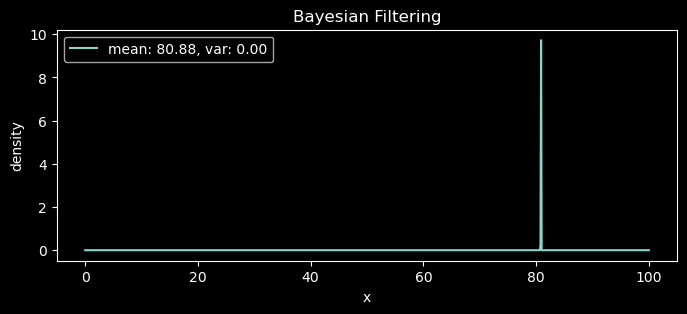

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from IPython.display import clear_output

# grid
x = np.linspace(0, 100, 1000)
dx = x[1] - x[0]

# (initial) prior: uniform on [0, 100]
prior = uniform.pdf(x, loc=0, scale=100)
prior /= np.trapezoid(prior, x)  # normalize
mean = np.trapezoid(prior * x, x)
var = np.trapezoid((x - mean)**2 * prior, x)

plt.figure(figsize=(8, 3))
plt.plot(x, prior, label=f'mean: {mean:.2f}, var: {var:.2f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.title('Bayesian Filtering')
plt.show()


while True: 
    
    # Step 1: Observe
    try: 
        observation, obs_sigma = input("observation obs_sigma: ").split()
    except ValueError:
        break
    
    observation = float(observation)
    obs_sigma = float(obs_sigma)
    
    likelihood = norm.pdf(x, loc=observation, scale=obs_sigma)

    # Step 2: Bayesian update: elementwise multiply, then normalize
    posterior = prior * likelihood
    posterior /= posterior.sum() * dx
    mean = np.trapezoid(posterior * x, x)
    var = np.trapezoid((x - mean)**2 * posterior, x)

    # plot
    clear_output(wait=True)
    plt.figure(figsize=(8, 3))
    plt.plot(x, posterior, label=f'mean: {mean:.2f}, var: {var:.2f}')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('density')
    plt.title('Bayesian Filtering')
    plt.show()

    prior = posterior


Because the observations and priors are Gaussian, the posterior is Gaussian as well. Additionally, the variance of the posterior distribution decreases no matter how improbable the observation! A feature, not a bug.

### 2. Kalman Filter

Same thing, but we add a transition model and a predictive step. Essentially, a there is a transition model and the model holds a belief of the first derivative of x. We assume linearity of the transition model and Gaussian. 

- Step 1: Observe
- Step 2: Update Beliefs
- Step 3: Predict

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from IPython.display import clear_output

# grid
x = np.linspace(0, 100, 1000)
dx = x[1] - x[0]

# (initial) prior: uniform on [0, 100]
prior = uniform.pdf(x, loc=0, scale=100)
prior /= np.trapezoid(prior, x)  # normalize
mean = np.trapezoid(prior * x, x)
var = np.trapezoid((x - mean)**2 * prior, x)


plt.plot(x, prior, label=f'mean: {mean:.2f}, var: {var:.2f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.title('Bayesian Filtering')
plt.show()


while True: 
    try: 
        observation, obs_sigma = input("observation obs_sigma: ").split()
    except ValueError:
        break
    
    observation = float(observation)
    obs_sigma = float(obs_sigma)
    
    likelihood = norm.pdf(x, loc=observation, scale=obs_sigma)

    # Bayesian update: elementwise multiple, then normalize
    posterior = prior * likelihood
    posterior /= posterior.sum() * dx
    mean = np.trapezoid(posterior * x, x)
    var = np.trapezoid((x - mean)**2 * posterior, x)

    # plot
    clear_output(wait=True)
    plt.plot(x, posterior, label=f'mean: {mean:.2f}, var: {var:.2f}')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('density')
    plt.title('Bayesian Filtering')
    plt.show()

    prior = posterior
